* By passenger, we mean someone in the building who is waiting to use or is currently using the elevator.
* The user of your classes should be able to customize the number of floors and passengers in the building.
* The passenger’s starting floor should be random, and they should have a random destination. (It’s up to you to determine what random should mean here.)
* Each passenger uses the elevator only once.
* (Would be nice) The program should have error checking to ensure valid user input.

In [2]:
from random import randint, choice
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
class Elevator(object):
    """An elevator class. 
    It has position, passengers inside and direction. 
    """

    def __init__(self, building, verbose, capacity = 10):
        self.current_floor = 0
        self.direction_up = True # True is up, False is down
        self.register_list = [] # passengers inside elevator
        self.capacity = capacity 
        self.verbose = verbose #whether we want to print or not
        self.building = building # reference to building, circular reference is okay in this case 
                                 # since we don't need to worry about garbage collection when each is 
                                 # only instantiated twice
                                 # http://engineering.hearsaysocial.com/2013/06/16/circular-references-in-python/          

    def move(self):
        """Method for elevator movement.
        In every step elevator either goes a floor higher or a floor lower.
        """
        self.current_floor += 1 if self.direction_up else -1
    
    def enter_passengers(self):
        """Method to get in all passengers and erase them from the list
        Gets waiting passengers at current floor as long as capacity permits and they are going in elevator direction
        """
        entered = False
        for passenger in [waiter for waiter in self.building.waiting_list]: # copy so we can rm from original list
            if (passenger.start_floor == self.current_floor and len(self.register_list) < self.capacity and
                (self.current_floor == 0 or self.current_floor == self.building.num_of_floors - 1 or 
                 (self.direction_up and passenger.start_floor < passenger.dst_floor) or 
                 (not self.direction_up and passenger.start_floor > passenger.dst_floor))):
                
                entered = True
                self.register_list.append(passenger)
                self.building.waiting_list.remove(passenger)
                if self.verbose: 
                    print ("Elevator picks up passenger %d on floor %d"% (passenger.ID, passenger.start_floor))
        return entered # return value so we can track if time cost was incurred
            
    def exit_passengers(self):
        """Function to remove all passengers on their destination floor.
        It is called in run method of the building class.
        """
        exited = False
        for passenger in [reg for reg in self.register_list]:
            if passenger.dst_floor == self.current_floor:
                exited = True
                self.register_list.remove(passenger)
                passenger.end_waittime = self.building.time_step
                self.building.list_of_waittimes.append(passenger.end_waittime - passenger.start_waittime)
                if self.verbose: 
                    print("Elevator drops off passenger %d on floor %d"% (passenger.ID, passenger.dst_floor))
        return exited # return value to track if time cost was incured

In [4]:
class Passenger(object):
    """A passenger class. 
    A passenger has his or her ID number, starting floor and destination floor number
    """

    def __init__(self, ID, floorsNum):
        """Initializes values for passenger and select random floors to start
        Destination floor and starting floor differ
        """
        self.ID = ID
        self.start_floor = choice([0] * (floorsNum // 2) + [i for i in range(floorsNum)])
        self.dst_floor = choice([0] * (self.start_floor != 0) * (floorsNum // 2) + [i for i in range(floorsNum) if i != self.start_floor])
        self.start_waittime = 0
        self.end_waittime = None

In [15]:
class Building(object):
    """A building class.
    Building had number of floors, list of passengers outside the elevator and its own elevator object.
    Strategy of an elevator is set by integer, where 0 is default and 1 is another very naive strategy.
    """
    MOVE_COST_FACTOR = 2
    ENTER_COST_FACTOR = 1
    EXIT_COST_FACTOR = 1 

    def __init__(self, strategy_func, floors = None, passengers = None, capacity = None, verbose = True):
        """Makes building class and addes list of passengers
        The list is sorted by starting floor value for efficacy.
        Manual input and parameter input of key params is supported
        """
        self.num_of_floors = floors or self.get_value("Please write number of floors in the building: ",\
                                   "Incorrect value. Number of floors should be an integer higher than 1.", 2)

        self.passengers_num = passengers or self.get_value("Please write number of passengers: ",\
                                    "Incorrect value. Number of passengers should be a non-negative integer.", 0)
        
        capacity = capacity or self.get_value("Please write maximum capacity of the elevator: ",\
                                    "Incorrect value. Capacity should be a non-negative integer.", 0)
        
        self.strategy_func = strategy_func
        self.verbose = verbose
        self.elevator = Elevator(self, verbose, capacity=capacity)
        self.time_step = 0 
        self.list_of_waittimes = [] 
        
        self.waiting_list = []
        for i in range(self.passengers_num):
            self.waiting_list.append(Passenger(i, self.num_of_floors))
            self.waiting_list = sorted(self.waiting_list, key=lambda x: x.start_floor) 
    
    def get_value(self, message, incorret_message, minimal):
        """Method for making sure to obtain integer input
        """
        val = None
        try:
            val = int(raw_input(message))
        except ValueError:
            print incorret_message
            return self.get_value(message, incorret_message, minimal)
        if val < minimal:
            print incorret_message
            return self.get_value(message, incorret_message, minimal)
        else:
            return val

    def run(self):
        """Runs the elevator until done, in each iteration:
        1. waiting passengers enter the elevator (register_passenger)
        2. the elevator is assigned a direction value
        3. elevator moves one floor up or down
        4. passengers on destination floors leaves the elevator (cancel_passenger)
        """        
        while self.waiting_list or self.elevator.register_list:
            exit = self.elevator.exit_passengers()
            enter = self.elevator.enter_passengers()
            self.strategy_func(self.elevator)
            self.elevator.move()
            self.time_step += Building.MOVE_COST_FACTOR * 1  + Building.EXIT_COST_FACTOR * exit + Building.ENTER_COST_FACTOR * enter 
        
        if self.verbose:  
            print "Wait time of passengers", self.list_of_waittimes
            plt.hist(self.list_of_waittimes, normed = True, bins=10)
            plt.show()
        return self.time_step

In [16]:
# Here we define the different strategies our elevator can follow
def direction_default_strategy(self):
    """Default function of elevator work - 
    it starts with going to the roof of building, then
    comes back to the first floor.
    """
    if self.current_floor >= self.building.num_of_floors:
         self.direction_up = False
    elif self.current_floor <= 0:
        self.direction_up = True

def direction_bad_strategy(self):
    """Example function of very bad strategy. Elevator takes desired floor of the first
    passenger and elevates him to desired location, then repeats for the next passenger.
    If no passenger is in elevator it just goes to the up and down, as in default strategy.
    """
    if len(self.register_list) is 0:
        direction_default_strategy(self)
        return
    firstval = self.register_list[0].dst_floor
    if self.current_floor > firstval:
        self.direction_up = False
    else:
        self.direction_up = True
        
def smart_train_strategy(self):
    """Similar to default -moving like a train- except it does not go all the way up or down
    if it has no reason to.
    """

    if self.direction_up: # check if there is something to do above
        cont = False
        for passenger in self.register_list: # needs to drop off?
            if passenger.dst_floor >= self.current_floor:
                cont = True
                break
        if not cont and len(self.register_list) < self.capacity: # can pick up
            for passenger in self.building.waiting_list: # need pick up?
                if passenger.start_floor >= self.current_floor:
                    cont = True
                    break
        if not cont:
            self.direction_up = False
    
    else: # check if continue going down?
        cont = False
        for passenger in self.register_list:
            if passenger.dst_floor <= self.current_floor:
                cont = True
                break
        if not cont and len(self.register_list) < self.capacity:
            for passenger in self.building.waiting_list:
                if passenger.start_floor <= self.current_floor:
                    cont = True
                    break
        if not cont:
            self.direction_up = True


Please write number of floors in the building: 5
Please write number of passengers: 4
Please write maximum capacity of the elevator: 2
Default Strategy
Elevator picks up passenger 0 on floor 0
Elevator picks up passenger 1 on floor 0
Elevator drops off passenger 0 on floor 2
Elevator drops off passenger 1 on floor 4
Elevator picks up passenger 2 on floor 4
Elevator picks up passenger 3 on floor 1
Elevator drops off passenger 2 on floor 0
Elevator drops off passenger 3 on floor 0
Wait time of passengers [5, 10, 25, 25]


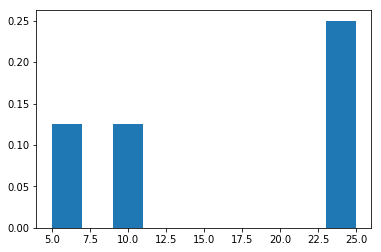

Number of steps for default strategy: 28
Bad Strategy
Elevator picks up passenger 0 on floor 0
Elevator picks up passenger 1 on floor 0
Elevator drops off passenger 0 on floor 2
Elevator drops off passenger 1 on floor 4
Elevator picks up passenger 2 on floor 4
Elevator picks up passenger 3 on floor 1
Elevator drops off passenger 2 on floor 0
Elevator drops off passenger 3 on floor 0
Wait time of passengers [5, 10, 21, 21]


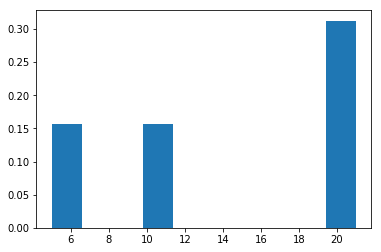

Number of steps for bad strategy: 24
Smart train strategy
Elevator picks up passenger 0 on floor 0
Elevator picks up passenger 1 on floor 0
Elevator drops off passenger 0 on floor 2
Elevator drops off passenger 1 on floor 4
Elevator picks up passenger 2 on floor 4
Elevator picks up passenger 3 on floor 1
Elevator drops off passenger 2 on floor 0
Elevator drops off passenger 3 on floor 0
Wait time of passengers [5, 10, 21, 21]


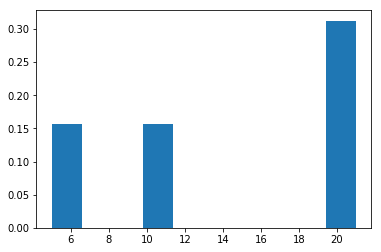

Number of steps for smart strategy: 24


In [24]:
def main():
    """Main function"""
    
    #Make a building and copy it's initialization, once per strategy
    building_def = Building(strategy_func = direction_default_strategy, verbose = True)
    building_bad = deepcopy(building_def)
    building_smart = deepcopy(building_def)
    
    print "Default Strategy"
    print "Number of steps for default strategy: " + str(building_def.run())
    
    print "Bad Strategy"
    building_bad.strategy_func = direction_bad_strategy
    print "Number of steps for bad strategy: " + str(building_bad.run())
    
    print "Smart train strategy"
    building_smart.strategy_func = smart_train_strategy
    print "Number of steps for smart strategy: " + str(building_smart.run())

if __name__ == "__main__":
    main()

In [25]:
def test_all(levels, passengers, capacity):
    building_def = Building(direction_default_strategy, levels, passengers, capacity, verbose = False)
    building_bad = deepcopy(building_def)
    building_smart = deepcopy(building_def)
    building_bad.strategy_func = direction_bad_strategy
    building_smart.strategy_func = smart_train_strategy
    
    return (building_def.run(), building_bad.run(), building_smart.run())
    
# for quick mass-testing in different scenarios
for i in range(50):
    # create test scenarios with random floors, passengers and capacity
    print test_all(randint(3, 50), randint(10, 100), randint(3, 20))

(317, 317, 313)
(444, 440, 432)
(58, 50, 46)
(170, 170, 162)
(162, 158, 150)
(193, 189, 185)
(144, 140, 136)
(440, 436, 428)
(195, 191, 191)
(480, 476, 448)
(444, 440, 428)
(362, 358, 346)
(42, 38, 38)
(318, 314, 310)
(237, 233, 233)
(205, 205, 193)
(251, 239, 207)
(156, 156, 152)
(203, 199, 199)
(161, 153, 145)
(345, 341, 337)
(94, 94, 90)
(296, 292, 280)
(330, 330, 326)
(53, 49, 45)
(513, 513, 497)
(249, 249, 245)
(212, 208, 140)
(204, 200, 192)
(116, 116, 112)
(690, 686, 674)
(259, 235, 207)
(105, 101, 97)
(255, 251, 247)
(1346, 1346, 1126)
(172, 168, 164)
(580, 580, 564)
(1128, 1124, 932)
(381, 377, 369)
(348, 344, 324)
(412, 408, 368)
(736, 732, 704)
(191, 187, 183)
(471, 471, 435)
(152, 148, 148)
(212, 208, 204)
(539, 535, 523)
(338, 334, 330)
(172, 172, 164)
(366, 366, 358)
